<a href="https://colab.research.google.com/github/solayman-cs/WindTurbine/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/NoteBooks/Unet-Dr_Rahman

/content/drive/My Drive/NoteBooks/Unet-Dr_Rahman


In [3]:
#import all the libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import skimage.io as io
from PIL import Image
from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from model import *

<ipython-input-3-6b3094a0ee79>:8: UserWarning: Viewer requires Qt
  from skimage.viewer import ImageViewer


In [4]:
def trainGenerator(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"*.png"))
    mask_name_arr = glob.glob(os.path.join(mask_path, "*.png"))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        img = img / 255
        image_arr.append(img)

    for index, item in enumerate(mask_name_arr):
        mask = io.imread(item, as_gray = image_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        mask = mask/255
        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

In [5]:
def testGenerator(test_path, image_num):
    for i in range(image_num):
        idx = str(i+1).zfill(5) + ".png"
        img = io.imread(os.path.join(test_path, idx), as_gray=True)
        img = img / 255
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [6]:
def getItem(img_path, item):
    idx = str(item+1).zfill(5) + ".png"
    img = io.imread(os.path.join(img_path, idx), as_gray=True)
    img = img/255.0
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,)+img.shape)
    return img

In [7]:
def saveResult(save_path, files):
    for i, item in enumerate(files):
        img = item[:,:,0]
        idx = str(i+1).zfill(5) + ".png"
        io.imsave(os.path.join(save_path, idx), img)

In [8]:
def viewImage(array1, array2, i):
    img = np.reshape(array1[i], (512, 512))
    mask = np.reshape(array2[i], (512, 512))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img, cmap=plt.cm.gray)
    axarr[1].imshow(mask, cmap=plt.cm.gray)
    plt.show()

(69, 512, 512, 1)
(69, 512, 512, 1)


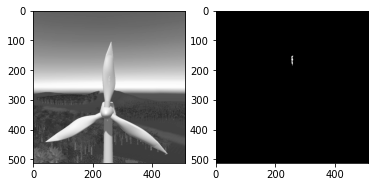

In [10]:
# Load the train data and their corresponding labels
# Visualize a sample image
imgs_train,imgs_mask_train= trainGenerator("train/images/","train/masks/")
print(imgs_train.shape)   
print(imgs_mask_train.shape)
index = np.random.randint(1, 50)
viewImage(imgs_train, imgs_mask_train, index)

In [11]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [13]:
from keras import backend as K
def jaccard_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [14]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(input_size = (512, 512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = [jaccard_loss], metrics = [dice_coef])

    return model



In [15]:
# laod model and show the model summary
model = unet()
model_checkpoint = ModelCheckpoint('windTurbine_segmentation.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# train the model
hm_epochs = 50
batch_size = 8
model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, epochs=hm_epochs, verbose=1,
          validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.3034 - dice_coef: 7.7041e-04
Epoch 1: loss improved from inf to 0.30336, saving model to windTurbine_segmentation.hdf5
7/7 [==============================] - 115s 13s/step - loss: 0.3034 - dice_coef: 7.7041e-04 - val_loss: 0.0036 - val_dice_coef: 0.0011
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 7.1114e-04 - dice_coef: 0.0066
Epoch 2: loss improved from 0.30336 to 0.00071, saving model to windTurbine_segmentation.hdf5
7/7 [==============================] - 23s 3s/step - loss: 7.1114e-04 - dice_coef: 0.0066 - val_loss: 5.0118e-04 - val_dice_coef: 0.0076
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 4.7329e-04 - dice_coef: 0.0081
Epoch 3: loss improved from 0.00071 to 0.00047, saving model to windTurbine_segmentation.hdf5
7/7 [==============================] - 23s 3s/step - loss: 4.7329e-04 - dice_coef: 0.0081 - val_loss: 4.9860e-04 - val_dice_coef: 0.0076
Epoch 4/50
7/7 [======

In [ ]:
# testing with new images
# the test image folder contains 30 images
test_path = 'test/images/'
test_image_arr = glob.glob(os.path.join(test_path, "*.png"))
num_of_test_images = len(test_image_arr)

testGene = testGenerator(test_path, num_of_test_images)

results = model.predict_generator(testGene, num_of_test_images, verbose=1)

# save the segmentation result in the "outputs" folder
saveResult("outputs/", results)

30/30 [==============================] - 1s 26ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [ ]:
# load the trained model
print("model loading...")
trained_model = load_model('fiber_segmentation.hdf5')
print("model loaded succesfully!!!")

model loading...
model loaded succesfully!!!
